## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [32]:
# TODO: Import the libraries.
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

In [42]:
# TODO: 1. Load images from folder into a list.
from tqdm import tqdm
import cv2
import os
from typing import List, Tuple
import numpy as np
import pandas as pd

def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    images = []
    labels = []

    subdirs = sorted(os.listdir(set_dir))
    is_test = all([file.lower().endswith(('.jpg', '.png')) for file in subdirs])

    if is_test:
        print("Loading testing set:", end=" ")
        for file in tqdm(sorted(subdirs, key=lambda x: int(x.split('.')[0]))):
            img_path = os.path.join(set_dir, file)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
        labels = []

    else:
        for class_name in subdirs:
            class_dir = os.path.join(set_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            print(f"Loading {class_name}:")
            for file in tqdm(sorted(os.listdir(class_dir))):
                img_path = os.path.join(class_dir, file)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(class_name)

    return images, labels

In [ ]:
from typing import Union, Tuple, List
from typing import Union, Tuple, List, Any
import cv2
from typing import List

def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    if not images:
        return np.array([])

    processed_images = []

    for idx, img in enumerate(images):
        try:
            if img is None or len(img.shape) != 3 or img.shape[2] != 3:
                print(f"[Warning] Image {idx} skipped due to invalid shape")
                continue

            h, w, _ = img.shape
            scale = target_size / min(h, w)
            new_h, new_w = int(h * scale), int(w * scale)
            resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

            # If the resized image is smaller than target_size, pad it
            if new_h < target_size or new_w < target_size:
                pad_h = max(0, target_size - new_h)
                pad_w = max(0, target_size - new_w)
                resized = cv2.copyMakeBorder(
                    resized,
                    top=pad_h // 2,
                    bottom=pad_h - pad_h // 2,
                    left=pad_w // 2,
                    right=pad_w - pad_w // 2,
                    borderType=cv2.BORDER_CONSTANT,
                    value=[0, 0, 0]  # fill with black pixels
                )
                new_h, new_w = resized.shape[:2]

            # Crop the center of the resized image to target_size
            start_x = (new_w - target_size) // 2
            start_y = (new_h - target_size) // 2
            cropped = resized[start_y:start_y + target_size, start_x:start_x + target_size]

            if cropped.shape[:2] != (target_size, target_size):
                print(f"[Warning] Cropped shape error on image {idx}")
                continue

            processed_images.append(cropped)

        except Exception as e:
            print(f"[Error] Image {idx} processing failed: {e}")
            continue

    return np.stack(processed_images) if processed_images else np.array([])

In [5]:
# Load images
images_train, labels_train = image_loader("../dataset_split/train")
images_val, labels_val = image_loader("../dataset_split/val")
images_test, _ = image_loader("../dataset_split/test")

Loading african_elephant:


100%|██████████| 780/780 [00:02<00:00, 281.68it/s]


Loading airliner:


100%|██████████| 780/780 [00:02<00:00, 384.64it/s]


Loading banana:


100%|██████████| 780/780 [00:02<00:00, 349.36it/s]


Loading convertible_car:


100%|██████████| 780/780 [00:02<00:00, 262.30it/s]


Loading golden_retriever:


100%|██████████| 780/780 [00:02<00:00, 284.17it/s]


Loading goldfish:


100%|██████████| 780/780 [00:02<00:00, 356.48it/s]


Loading parachute:


100%|██████████| 780/780 [00:02<00:00, 334.11it/s]


Loading rugby:


100%|██████████| 780/780 [00:02<00:00, 262.61it/s]


Loading sunglasses:


100%|██████████| 780/780 [00:02<00:00, 332.74it/s]


Loading tiger_cat:


100%|██████████| 780/780 [00:02<00:00, 276.78it/s]


Loading african_elephant:


100%|██████████| 260/260 [00:00<00:00, 262.28it/s]


Loading airliner:


100%|██████████| 260/260 [00:00<00:00, 366.55it/s]


Loading banana:


100%|██████████| 260/260 [00:00<00:00, 307.63it/s]


Loading convertible_car:


100%|██████████| 260/260 [00:00<00:00, 264.38it/s]


Loading golden_retriever:


100%|██████████| 260/260 [00:01<00:00, 245.15it/s]


Loading goldfish:


100%|██████████| 260/260 [00:01<00:00, 235.44it/s]


Loading parachute:


100%|██████████| 260/260 [00:00<00:00, 325.03it/s]


Loading rugby:


100%|██████████| 260/260 [00:01<00:00, 244.96it/s]


Loading sunglasses:


100%|██████████| 260/260 [00:00<00:00, 290.45it/s]


Loading tiger_cat:


100%|██████████| 260/260 [00:01<00:00, 237.56it/s]


Loading testing set: 

100%|██████████| 2600/2600 [00:09<00:00, 260.28it/s]


In [6]:
# Resize the images
images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

In [7]:
#TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].
images_train = images_train.astype(np.float32) / 255.0
images_val = images_val.astype(np.float32) / 255.0
images_test = images_test.astype(np.float32) / 255.0

In [ ]:
print(images_train.shape)
print(images_val.shape)
print(images_test.shape)

(7800, 224, 224, 3)
(2600, 224, 224, 3)
(2600, 224, 224, 3)


In [9]:
# TODO: 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
tensor_train = torch.from_numpy(images_train).permute(0, 3, 1, 2)
tensor_val = torch.from_numpy(images_val).permute(0, 3, 1, 2)
tensor_test = torch.from_numpy(images_test).permute(0, 3, 1, 2)

In [10]:
# TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).

# Step 1: Compute per-channel mean and std from training set
train_mean = tensor_train.mean(dim=(0, 2, 3), keepdim=True)
train_std = tensor_train.std(dim=(0, 2, 3), keepdim=True)

# Step 2: Normalize all sets using training stats
tensor_train = (tensor_train - train_mean) / train_std
tensor_val = (tensor_val - train_mean) / train_std
tensor_test = (tensor_test - train_mean) / train_std


In [11]:
print("Mean per channel:", train_mean.flatten())
print("Std per channel:", train_std.flatten())

Mean per channel: tensor([0.4082, 0.4628, 0.4884])
Std per channel: tensor([0.2827, 0.2592, 0.2708])


In [12]:
# TODO: 6. Save the pre-processed sets as .pt files.

# 6.1 Save the tensor_train, tensor_val, and tensor_test as tensor_train.pt, tensor_val.pt, and tensor_test.pt, respectively.
torch.save(tensor_train, "tensor_train.pt")
torch.save(tensor_val, "tensor_val.pt")
torch.save(tensor_test, "tensor_test.pt")

# 6.2 Create a list to map index to label and a dictionary to map label to index.
unique_labels = sorted(set(labels_train))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}


# 6.3 Map the labels to index.
labels_train_index = torch.tensor([label_to_index[label] for label in labels_train])
labels_val_index = torch.tensor([label_to_index[label] for label in labels_val])

# 6.4 Save the index, label_to_index, and index_to_label.
torch.save(labels_train_index, "labels_train.pt")
torch.save(labels_val_index, "labels_val.pt")
torch.save(label_to_index, "label_to_index.pt")
torch.save({v: k for k, v in label_to_index.items()}, "index_to_label.pt")

In [2]:
# TODO: 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

# Load image tensors
tensor_train = torch.load("tensor_train.pt")
tensor_val = torch.load("tensor_val.pt")
tensor_test = torch.load("tensor_test.pt")

# Load label tensors
labels_train_index = torch.load("labels_train.pt")
labels_val_index = torch.load("labels_val.pt")

C:\Users\nvgip\AppData\Local\Temp\ipykernel_55612\1349405462.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_train = torch.load("tensor_train.pt")
C:\Users\nvgip\

In [3]:
print("Train tensor:", tensor_train.shape)
print("Val tensor:", tensor_val.shape)
print("Test tensor:", tensor_test.shape)
print("Train labels:", labels_train_index.shape)
print("Val labels:", labels_val_index.shape)

Train tensor: torch.Size([7800, 3, 224, 224])
Val tensor: torch.Size([2600, 3, 224, 224])
Test tensor: torch.Size([2600, 3, 224, 224])
Train labels: torch.Size([7800])
Val labels: torch.Size([2600])


# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [ ]:
# TODO: 1. Set hyperparameters for the training process.

MAX_EPOCH = 20
INIT_LR = 0.001
BATCH_SIZE = 128

# Specify the training device (automatically detects GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ——————————————————————————————————————————————————————————
# TODO: 2. Create a pretrained ResNet34.
from torchvision import models
import torch.nn as nn

# 2.1 Use torchvision to create a pretrained ResNet34.
resnet34 = models.resnet34(pretrained=True)

# 2.2 Modify the output layer so that the model aligns with this project.
num_classes = 10
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)

# 2.2 Move the model to selected device.
resnet34 = resnet34.to(device)


# ——————————————————————————————————————————————————————————
# TODO: 3. Define the optimizer, loss function, etc.
import torch.optim as optim

optimizer = optim.SGD(resnet34.parameters(), lr=INIT_LR, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

criterion = nn.CrossEntropyLoss()


# ——————————————————————————————————————————————————————————
# TODO: 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
# Hint: May not need too many epochs as this is a pretrained model.

train_accs_resnet34, train_losses_resnet34 = [], []
val_accs_resnet34, val_losses_resnet34 = [], []


d:\Anoconda\envs\MSA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anoconda\envs\MSA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc



def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc



def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs):
    best_val_acc = 0.0
    patience = 5  # allow maximum of 5 epochs without improvement
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        print(f"\n📘 Epoch [{epoch+1}/{num_epochs}]")

        # train and evaluate
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        scheduler.step()

        # record losses and accuracies
        train_losses_resnet34.append(train_loss)
        train_accs_resnet34.append(train_acc)
        val_losses_resnet34.append(val_loss)
        val_accs_resnet34.append(val_acc)

        print(f"🔹 Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f}")
        print(f"🔸 Val   Loss: {val_loss:.4f}  Acc: {val_acc:.4f}")

        # Checkpoint saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'resnet34_checkpoint.pkl')
            print("✅ Saved new best model.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⚠️ No improvement for {epochs_no_improve} epoch(s).")

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping triggered at epoch {epoch+1}. Best Val Acc: {best_val_acc:.4f}")
            break

    print("\n🎯 Training finished. Best Val Acc: {:.4f}".format(best_val_acc))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# 构建 Dataset
train_dataset = TensorDataset(tensor_train, labels_train_index)
val_dataset = TensorDataset(tensor_val, labels_val_index)

# 构建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
# iniitial learning rate = 0.001
train_model(
    model=resnet34,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=MAX_EPOCH
)


📘 Epoch [1/20]
🔹 Train Loss: 0.7699  Acc: 0.8249
🔸 Val   Loss: 0.1681  Acc: 0.9696
✅ Saved new best model.

📘 Epoch [2/20]
🔹 Train Loss: 0.1271  Acc: 0.9754
🔸 Val   Loss: 0.1051  Acc: 0.9758
✅ Saved new best model.

📘 Epoch [3/20]
🔹 Train Loss: 0.0795  Acc: 0.9867
🔸 Val   Loss: 0.0849  Acc: 0.9788
✅ Saved new best model.

📘 Epoch [4/20]
🔹 Train Loss: 0.0576  Acc: 0.9904
🔸 Val   Loss: 0.0729  Acc: 0.9804
✅ Saved new best model.

📘 Epoch [5/20]
🔹 Train Loss: 0.0437  Acc: 0.9929
🔸 Val   Loss: 0.0658  Acc: 0.9808
✅ Saved new best model.

📘 Epoch [6/20]
🔹 Train Loss: 0.0340  Acc: 0.9958
🔸 Val   Loss: 0.0610  Acc: 0.9823
✅ Saved new best model.

📘 Epoch [7/20]
🔹 Train Loss: 0.0286  Acc: 0.9959
🔸 Val   Loss: 0.0581  Acc: 0.9812
⚠️ No improvement for 1 epoch(s).

📘 Epoch [8/20]
🔹 Train Loss: 0.0229  Acc: 0.9972
🔸 Val   Loss: 0.0557  Acc: 0.9819
⚠️ No improvement for 2 epoch(s).

📘 Epoch [9/20]
🔹 Train Loss: 0.0189  Acc: 0.9986
🔸 Val   Loss: 0.0536  Acc: 0.9815
⚠️ No improvement for 3 epoch(s)

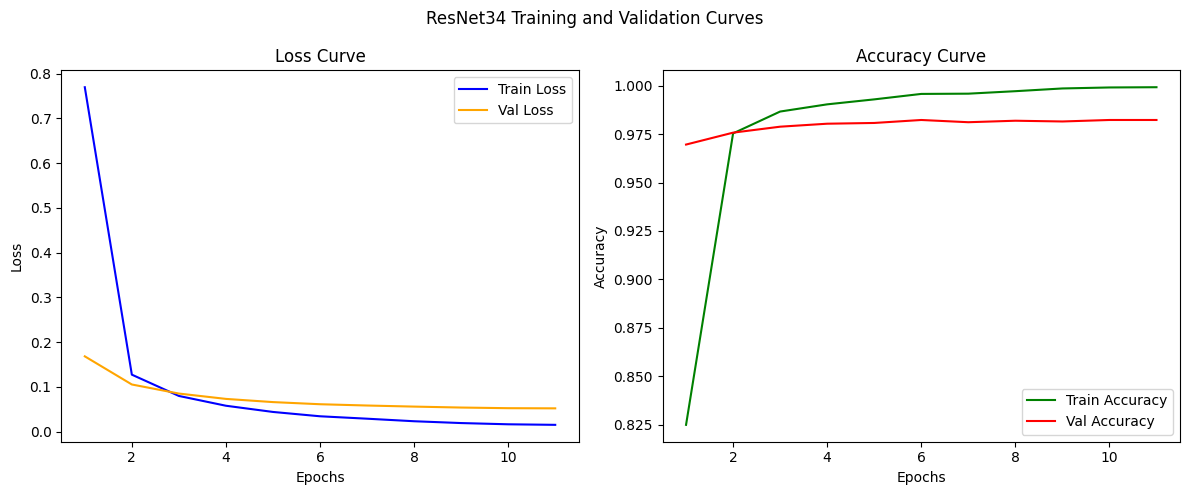

In [20]:
# plot the loss and accuracy curves
def plot_curves(train_accs, train_losses, val_accs, val_losses, title
                = "Training and Validation Curves"):
        epochs = range(1, len(train_losses) + 1)
    
        plt.figure(figsize=(12, 5))
    
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss', color='blue')
        plt.plot(epochs, val_losses, label='Val Loss', color='orange')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    
        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accs, label='Train Accuracy', color='green')
        plt.plot(epochs, val_accs, label='Val Accuracy', color='red')
        plt.title('Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

# Plot the training and validation curves
plot_curves(train_accs_resnet34, train_losses_resnet34, 
            val_accs_resnet34, val_losses_resnet34, 
            title="ResNet34 Training and Validation Curves")



# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [4]:
# Verify data shapes
num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [38]:
# TODO: 1. Set hyperparameters for the distillation process.

MAX_EPOCH = 80
INIT_LR = 0.001
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEMPERATURE = 4
LOSS_RATIO = 0.7

In [ ]:
import mlflow
print("MLflow version:", mlflow.__version__)

MLflow version: 3.1.1


In [ ]:
# TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.

from torchvision import models
from torchvision.models import resnet18


# create a NON-PRETRAINED ResNet18
resnet18 = resnet18(weights=None)  # not loading ImageNet weights
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 10)  # modify classification head for 10 classes
resnet18 = resnet18.to(device)                         # move to GPU or CPU

In [ ]:
# TODO: 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

from torchvision.models import resnet34

# initialize a NON-PRETRAINED ResNet34
resnet34 = resnet34(weights=None)
resnet34.fc = torch.nn.Linear(resnet34.fc.in_features, 10)

# load the pretrained weights
resnet34.load_state_dict(torch.load("resnet34_checkpoint.pkl", weights_only=True))

# eaval mode and move to device
resnet34.eval()
resnet34 = resnet34.to(device)


In [ ]:
# TODO: 4. Define the optimizer AND scheduler for the training process.

# Define Optimizer and Scheduler
optimizer = torch.optim.Adam(resnet18.parameters(), lr=INIT_LR, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
# Define the loss function

import torch.nn.functional as F

ce_loss_fn = torch.nn.CrossEntropyLoss()  # Cross-entropy loss for classification

def distillation_loss(student_logits, teacher_logits, labels, T, alpha):
    """
    Compute the total knowledge distillation loss.
    
    This includes:
    - KL divergence loss between softened student and teacher predictions
    - Cross-entropy loss between student predictions and true labels

    Args:
        student_logits: Output logits from the student model
        teacher_logits: Output logits from the teacher model (no softmax applied)
        labels: Ground truth class labels
        T: Temperature parameter for softening probabilities
        alpha: Weighting factor for KD loss (between 0 and 1)

    Returns:
        total_loss: Weighted sum of KD loss and CE loss (Tensor, used for backprop)
        loss_kd.item(): KL divergence loss (float, for logging)
        loss_ce.item(): Cross-entropy loss (float, for logging)
    """
    # Softened predictions from student and teacher
    student_soft = F.log_softmax(student_logits / T, dim=1)
    teacher_soft = F.softmax(teacher_logits / T, dim=1)

    # KL divergence loss (scaled by T^2 as per the original distillation paper)
    loss_kd = F.kl_div(student_soft, teacher_soft, reduction='batchmean') * (T * T)

    # Cross-entropy loss with ground truth labels
    loss_ce = ce_loss_fn(student_logits, labels)

    # Weighted combination of the two losses
    total_loss = alpha * loss_kd + (1 - alpha) * loss_ce

    return total_loss, loss_kd.item(), loss_ce.item()


In this experiment, a dual-metric saving strategy was used during the training of the student model: the primary metric was val_acc, and the secondary was val_loss.  
This ensures optimal performance in both classification accuracy and distillation alignment. Early stopping was triggered if no improvement was observed for several consecutive epochs, preventing overfitting and reducing unnecessary resource consumption.

In [12]:
def train_one_epoch(model, teacher, dataloader, optimizer, device, T, alpha, loss_fn):
    model.train()
    teacher.eval()

    total_loss = 0.0
    total_kd_loss = 0.0
    total_ce_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        student_logits = model(images)
        with torch.no_grad():
            teacher_logits = teacher(images)

        loss, loss_kd_val, loss_ce_val = loss_fn(student_logits, teacher_logits, labels, T, alpha)
        loss.backward()
        optimizer.step()

        # Accumulate losses and accuracy
        total_loss += loss.item() * images.size(0)
        total_kd_loss += loss_kd_val * images.size(0)
        total_ce_loss += loss_ce_val * images.size(0)

        _, preds = torch.max(student_logits, dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate averages
    avg_loss = total_loss / total_samples
    avg_kd_loss = total_kd_loss / total_samples
    avg_ce_loss = total_ce_loss / total_samples
    avg_acc = total_correct / total_samples

    return avg_loss, avg_kd_loss, avg_ce_loss, avg_acc

In [13]:
def validate(model, teacher, dataloader, device, T, alpha, loss_fn):
    model.eval()
    teacher.eval()

    total_loss = 0.0
    total_kd_loss = 0.0
    total_ce_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            student_logits = model(images)
            teacher_logits = teacher(images)

            loss, loss_kd_val, loss_ce_val = loss_fn(student_logits, teacher_logits, labels, T, alpha)

            total_loss += loss.item() * images.size(0)
            total_kd_loss += loss_kd_val * images.size(0)
            total_ce_loss += loss_ce_val * images.size(0)

            _, preds = torch.max(student_logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    avg_kd_loss = total_kd_loss / total_samples
    avg_ce_loss = total_ce_loss / total_samples
    avg_acc = total_correct / total_samples

    return avg_loss, avg_kd_loss, avg_ce_loss, avg_acc


In [14]:
def maybe_save_model(model, val_acc, val_loss, best_acc, best_loss, epochs_no_improve, patience, path='resnet18_checkpoint.pkl'):
    if (val_acc > best_acc) or (val_acc == best_acc and val_loss < best_loss):
        best_acc = val_acc
        best_loss = val_loss
        torch.save(model.state_dict(), path)
        print("✅ Saved new best model (val_acc ↑ or val_loss ↓).")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping triggered after {patience} epochs with no improvement.")
            return best_acc, best_loss, epochs_no_improve, True
    return best_acc, best_loss, epochs_no_improve, False


In [15]:
def train_student_model(model, teacher, train_loader, val_loader, optimizer, scheduler, device,
                        T, alpha, loss_fn, max_epoch, patience):
    best_val_acc = 0.0
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(max_epoch):
        print(f"\n📘 Epoch [{epoch+1}/{max_epoch}]")

        # Get total loss, kd loss, ce loss, and accuracy for training and validation
        train_loss, train_kd, train_ce, train_acc = train_one_epoch(
            model, teacher, train_loader, optimizer, device, T, alpha, loss_fn)
        
        val_loss, val_kd, val_ce, val_acc = validate(
            model, teacher, val_loader, device, T, alpha, loss_fn)

        scheduler.step()

        # Print metrics for this epoch
        print(f"🔹 Train Loss: {train_loss:.4f} (KD: {train_kd:.4f}, CE: {train_ce:.4f})  Acc: {train_acc:.4f}")
        print(f"🔸 Val   Loss: {val_loss:.4f} (KD: {val_kd:.4f}, CE: {val_ce:.4f})  Acc: {val_acc:.4f}")

        # Log metrics to MLflow
        mlflow.log_metrics({
            "train_loss": train_loss,
            "train_kd": train_kd,
            "train_ce": train_ce,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_kd": val_kd,
            "val_ce": val_ce,
            "val_acc": val_acc
        }, step=epoch)

        # Save model if improved and check early stopping
        best_val_acc, best_val_loss, epochs_no_improve, stop = maybe_save_model(
            model, val_acc, val_loss, best_val_acc, best_val_loss, epochs_no_improve, patience
        )

        if stop:
            break


In [ ]:
import mlflow
import mlflow.pytorch


with mlflow.start_run(run_name="resnet18_kd_baseline"):
    # record hyperparameters
    mlflow.log_param("model", "resnet18_student")
    mlflow.log_param("teacher_model", "resnet34")
    mlflow.log_param("init_lr", INIT_LR)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("temperature", TEMPERATURE)
    mlflow.log_param("loss_ratio", LOSS_RATIO)
    mlflow.log_param("max_epoch", MAX_EPOCH)


    # start training
    train_student_model(resnet18, resnet34,
                        train_loader, val_loader,
                        optimizer, scheduler, device,
                        T=TEMPERATURE, alpha=LOSS_RATIO,
                        loss_fn=distillation_loss,
                        max_epoch=MAX_EPOCH, patience=10)

    # save model to MLflow
    mlflow.pytorch.log_model(resnet18, "resnet18_student_model")


📘 Epoch [1/80]
🔹 Train Loss: 3.4969 (KD: 4.3360, CE: 1.5392)  Acc: 0.5176
🔸 Val   Loss: 2.7819 (KD: 3.4237, CE: 1.2844)  Acc: 0.6200
✅ Saved new best model (val_acc ↑ or val_loss ↓).

📘 Epoch [2/80]
🔹 Train Loss: 2.5942 (KD: 3.2000, CE: 1.1807)  Acc: 0.6494
🔸 Val   Loss: 2.8504 (KD: 3.4716, CE: 1.4010)  Acc: 0.6327
✅ Saved new best model (val_acc ↑ or val_loss ↓).

📘 Epoch [3/80]
🔹 Train Loss: 2.1311 (KD: 2.6327, CE: 0.9607)  Acc: 0.7137
🔸 Val   Loss: 2.8203 (KD: 3.3994, CE: 1.4690)  Acc: 0.6208
⚠️ No improvement for 1 epoch(s).

📘 Epoch [4/80]
🔹 Train Loss: 1.8179 (KD: 2.2471, CE: 0.8166)  Acc: 0.7594
🔸 Val   Loss: 1.9273 (KD: 2.3604, CE: 0.9168)  Acc: 0.7458
✅ Saved new best model (val_acc ↑ or val_loss ↓).

📘 Epoch [5/80]
🔹 Train Loss: 1.6731 (KD: 2.0695, CE: 0.7481)  Acc: 0.7801
🔸 Val   Loss: 1.8938 (KD: 2.3197, CE: 0.9001)  Acc: 0.7381
⚠️ No improvement for 1 epoch(s).

📘 Epoch [6/80]
🔹 Train Loss: 1.5088 (KD: 1.8729, CE: 0.6593)  Acc: 0.8037
🔸 Val   Loss: 1.8420 (KD: 2.2454, CE:

2025/07/10 23:48:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🔹 Train Loss: 0.0558 (KD: 0.0713, CE: 0.0196)  Acc: 0.9991
🔸 Val   Loss: 0.7153 (KD: 0.8754, CE: 0.3419)  Acc: 0.8962
⚠️ No improvement for 10 epoch(s).
⏹️ Early stopping triggered after 10 epochs with no improvement.


2025/07/10 23:48:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/10 23:49:19 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/10 23:49:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Load logged data from MLflow for subsequent model performance visualization

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient

client = MlflowClient()

# obtain the latest run
experiment = client.get_experiment_by_name("Default") 
runs = client.search_runs(experiment.experiment_id, order_by=["start_time DESC"], max_results=1)
run = runs[0]  # the latest run

run_id = run.info.run_id

# read metric history
metric_history = {
    "train_loss": client.get_metric_history(run_id, "train_loss"),
    "val_loss": client.get_metric_history(run_id, "val_loss"),
    "train_acc": client.get_metric_history(run_id, "train_acc"),
    "val_acc": client.get_metric_history(run_id, "val_acc")
}

# sorted metric values by step
train_losses_resnet18 = [m.value for m in sorted(metric_history["train_loss"], key=lambda x: x.step)]
val_losses_resnet18 = [m.value for m in sorted(metric_history["val_loss"], key=lambda x: x.step)]
train_accs_resnet18 = [m.value for m in sorted(metric_history["train_acc"], key=lambda x: x.step)]
val_accs_resnet18 = [m.value for m in sorted(metric_history["val_acc"], key=lambda x: x.step)]


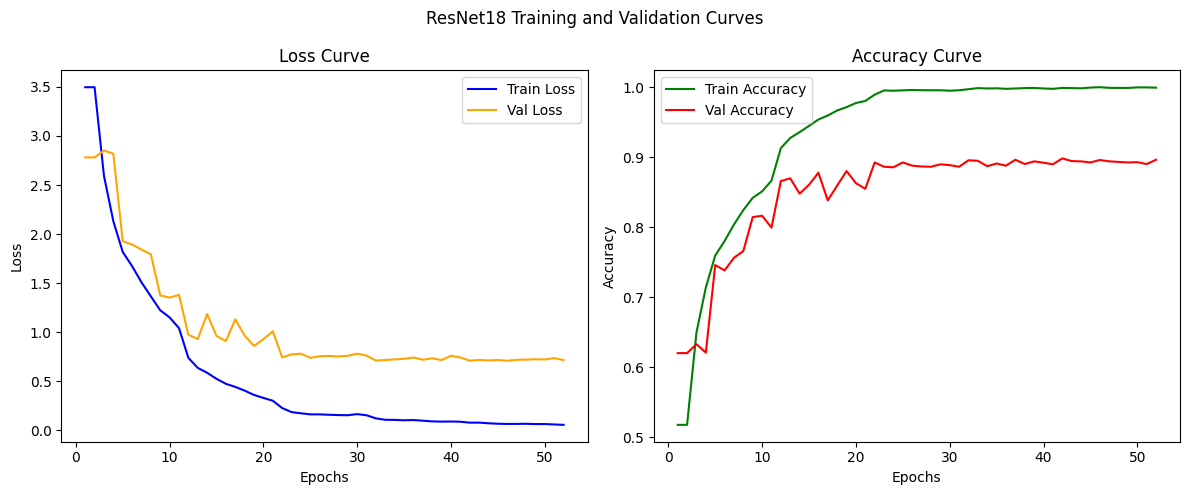

In [33]:
# TODO: 6. Plot the loss and accuracy curves.

# Plot the training and validation curves
plot_curves(train_accs_resnet18, train_losses_resnet18, 
            val_accs_resnet18, val_losses_resnet18, 
            title="ResNet18 Training and Validation Curves")

# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [35]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

import torch
from torchvision.models import resnet18

# create a NON-PRETRAINED ResNet18
resnet18 = resnet18(weights=None, num_classes=10) # 
resnet18.load_state_dict(torch.load("resnet18_checkpoint.pkl", map_location=device))
resnet18.to(device)
resnet18.eval()  # set to evaluation mode

C:\Users\nvgip\AppData\Local\Temp\ipykernel_55612\1940301695.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18.load_state_dict(torch.load("resnet18_checkpoint.pkl

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch

tensor_test = torch.load("tensor_test.pt")

print(f"type: {type(tensor_test)}")
print(f"shape: {tensor_test.shape}")
print(f"data type: {tensor_test.dtype}")

C:\Users\nvgip\AppData\Local\Temp\ipykernel_55612\2329625727.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_test = torch.load("tensor_test.pt")


type: <class 'torch.Tensor'>
shape: torch.Size([2600, 3, 224, 224])
data type: torch.float32


In [39]:
# TODO: 2. Do prediction using the images in the testing set.

from torch.utils.data import DataLoader, TensorDataset
import torch

# load the saved ResNet18 model
resnet18.load_state_dict(torch.load("resnet18_checkpoint.pkl", map_location=device))
resnet18.to(device)
resnet18.eval()

# load the pre-processed testing set
tensor_test = torch.load("tensor_test.pt")
test_dataset = TensorDataset(tensor_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# save predictions
predictions = []
with torch.no_grad():
    for images_batch in test_loader:
        images = images_batch[0].to(device)
        outputs = resnet18(images)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())


C:\Users\nvgip\AppData\Local\Temp\ipykernel_55612\3239429701.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18.load_state_dict(torch.load("resnet18_checkpoint.pkl

In [40]:
# load index_to_label mapping
index_to_label =  torch.load("index_to_label.pt", weights_only=True)

print("Index of predictions:", predictions[:20]) 
print("Lable of Predictions:", [index_to_label[idx] for idx in predictions[:20]]) 

Index of predictions: [8, 3, 1, 4, 0, 0, 7, 8, 4, 0, 0, 3, 0, 0, 3, 8, 8, 7, 9, 8]
Lable of Predictions: ['sunglasses', 'convertible_car', 'airliner', 'golden_retriever', 'african_elephant', 'african_elephant', 'rugby', 'sunglasses', 'golden_retriever', 'african_elephant', 'african_elephant', 'convertible_car', 'african_elephant', 'african_elephant', 'convertible_car', 'sunglasses', 'sunglasses', 'rugby', 'tiger_cat', 'sunglasses']


In [ ]:
# TODO: 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...

label_names = [index_to_label[idx] for idx in predictions]  # obtain label names from predictions
file_names = [f"{i}.jpg" for i in range(len(label_names))]

df = pd.DataFrame({
    "file_name": file_names,
    "label": label_names
})

df.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.


# Supplementary analysis

**Reload both models for further analysis:**
- Analyze the output distribution of the teacher model
- Compare confusion matrices of the teacher and student
- Compare per-class accuracy
- Visualize training losses over time


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load validation image and label tensors
tensor_val = torch.load("tensor_val.pt")              # Shape: [N, C, H, W]
labels_val_index = torch.load("labels_val.pt")        # Shape: [N]

# Wrap tensors into a dataset
val_dataset = TensorDataset(tensor_val, labels_val_index)

# Create a DataLoader for the validation set
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


C:\Users\nvgip\AppData\Local\Temp\ipykernel_55612\4076266266.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_val = torch.load("tensor_val.pt")              # Shap

## Output distribution of the teacher model

In [ ]:
from torchvision.models import resnet34
from torchvision.models import resnet18

# Initialize the two models with the correct number of output classes
teacher_model = resnet34(num_classes=10)
student_model = resnet18(num_classes=10)

# Load saved model weights (update path as needed)
teacher_model.load_state_dict(torch.load(r"D:\Github\MSA 2025\2025-Phase-2\data-science\3. Deep Learning Project\src\resnet34_checkpoint.pkl"))
student_model.load_state_dict(torch.load(r"D:\Github\MSA 2025\2025-Phase-2\data-science\3. Deep Learning Project\src\resnet18_checkpoint.pkl"))

# Set model to evaluation mode to disable dropout/batchnorm updates
teacher_model.eval()
student_model.eval()

C:\Users\nvgip\AppData\Local\Temp\ipykernel_55612\2106151212.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load(r"D:\Github\MSA 202

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

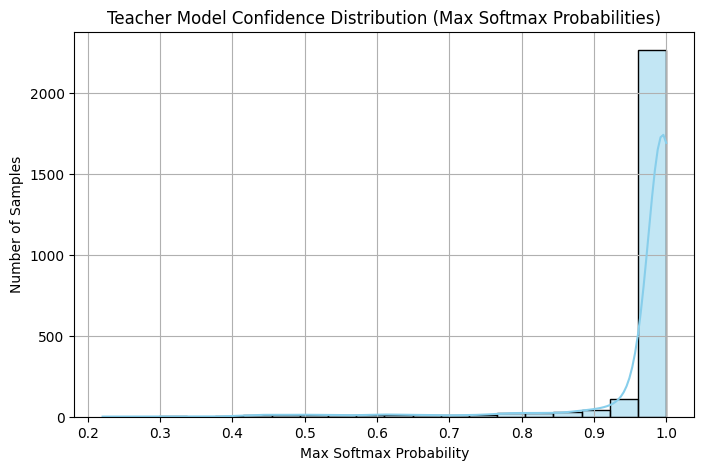

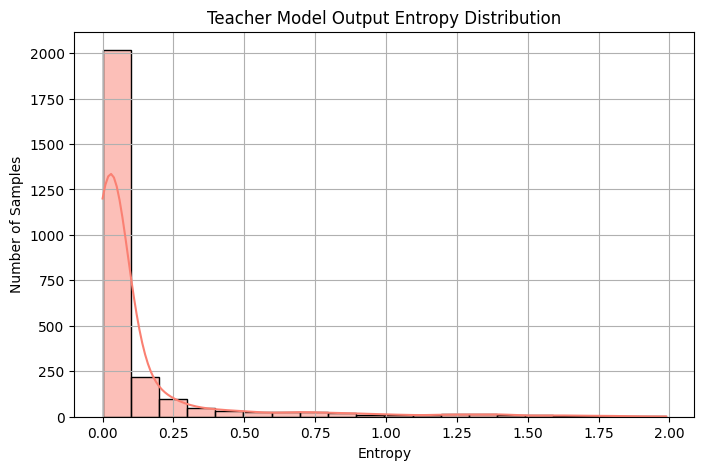

In [17]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

# List to store softmax probabilities for all validation samples
teacher_softmax_outputs = []

# Disable gradient tracking for inference
with torch.no_grad():
    for images, _ in val_loader:
        logits = teacher_model(images)              # Forward pass to get logits
        probs = F.softmax(logits, dim=1)            # Convert logits to softmax probabilities
        teacher_softmax_outputs.append(probs.cpu().numpy()) # Move to CPU and convert to numpy

# Concatenate all outputs into a single NumPy array (shape: [N, num_classes])
teacher_softmax_outputs_all = np.concatenate(teacher_softmax_outputs, axis=0)

# Compute max softmax value (i.e., confidence) for each sample
max_probs = np.max(teacher_softmax_outputs_all, axis=1)

# Plot histogram of confidence scores
plt.figure(figsize=(8, 5))
sns.histplot(max_probs, bins=20, kde=True, color='skyblue')
plt.title("Teacher Model Confidence Distribution (Max Softmax Probabilities)")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


# Compute entropy for each softmax output vector
entropies = entropy(teacher_softmax_outputs_all, axis=1)

# Plot histogram of entropy values
plt.figure(figsize=(8, 5))
sns.histplot(entropies, bins=20, kde=True, color='salmon')
plt.title("Teacher Model Output Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


Softmax distribution after temperature smoothing

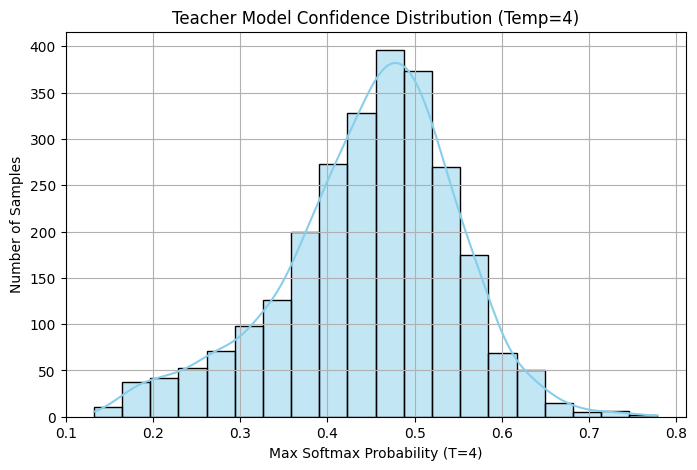

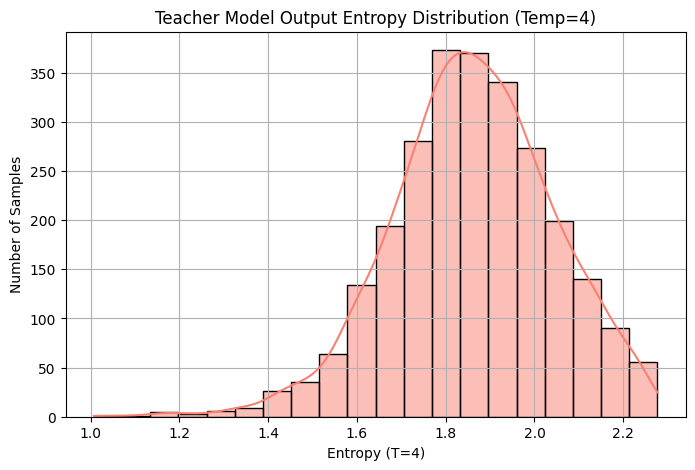

In [ ]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


temperature = 4.0 

# Compute temperature-scaled softmax
softmax_outputs_temp = []

with torch.no_grad():
    for images, _ in val_loader:
        logits = teacher_model(images)
        logits_temp = logits / temperature  # Apply temperature scaling
        probs_temp = F.softmax(logits_temp, dim=1)
        softmax_outputs_temp.append(probs_temp.cpu().numpy())

# Concatenate all predictions
softmax_outputs_temp_all = np.concatenate(softmax_outputs_temp, axis=0)



### Visualize Max Softmax Distribution (after Temperature Scaling)
# Compute max probability for each sample
max_probs_temp = np.max(softmax_outputs_temp_all, axis=1)

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(max_probs_temp, bins=20, kde=True, color='skyblue')
plt.title("Teacher Model Confidence Distribution (Temp=4)")
plt.xlabel("Max Softmax Probability (T=4)")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

### Visualize Entropy Distribution (after Temperature Scaling
# Compute entropy per sample
entropies_temp = entropy(softmax_outputs_temp_all, axis=1)

# Plot histogram of entropy
plt.figure(figsize=(8, 5))
sns.histplot(entropies_temp, bins=20, kde=True, color='salmon')
plt.title("Teacher Model Output Entropy Distribution (Temp=4)")
plt.xlabel("Entropy (T=4)")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

## Confusion matrices of the teacher and student

In [ ]:
def get_predictions(model, dataloader):
    """
    Run inference on the given model and dataloader.
    Return predicted class indices for all samples.
    """
    model.eval()
    preds = []

    with torch.no_grad():
        for images, _ in dataloader:
            outputs = model(images)                   # Forward pass
            predicted_classes = torch.argmax(outputs, dim=1)  # Get class with highest logit
            preds.append(predicted_classes.cpu())     # Move to CPU

    return torch.cat(preds).numpy()  # Concatenate and convert to NumPy


teacher_preds = get_predictions(teacher_model, val_loader)
student_preds = get_predictions(student_model, val_loader)

C:\Users\nvgip\AppData\Local\Temp\ipykernel_55612\294498338.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  index_to_label = torch.load("index_to_label.pt")


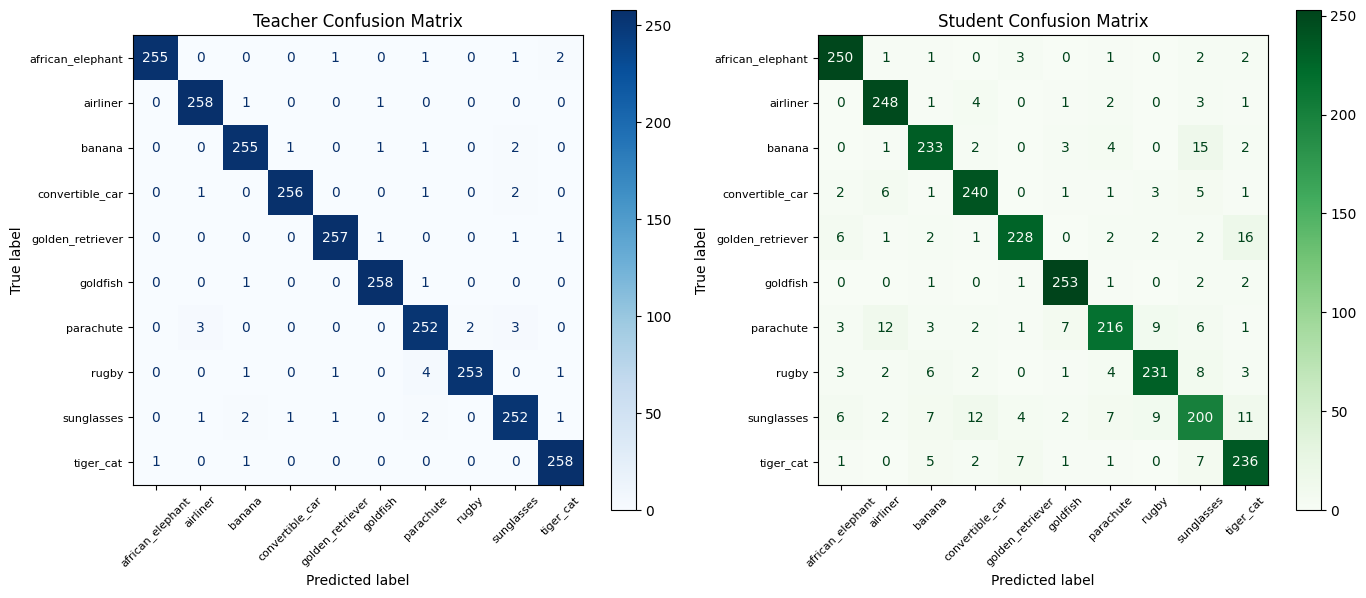

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# True labels
y_true = torch.cat([y for _, y in val_loader]).numpy()

# Compute confusion matrices
cm_teacher = confusion_matrix(y_true, teacher_preds)
cm_student = confusion_matrix(y_true, student_preds)

# Load the index_to_label mapping
index_to_label = torch.load("index_to_label.pt")

# Ensure it's sorted by index (just in case it's a dict)
class_names = [index_to_label[i] for i in range(len(index_to_label))]

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Slightly larger figsize for more room

# Teacher matrix
disp1 = ConfusionMatrixDisplay(cm_teacher, display_labels=class_names)
disp1.plot(ax=axes[0], cmap='Blues', xticks_rotation=45)
axes[0].set_title("Teacher Confusion Matrix")

# Student matrix
disp2 = ConfusionMatrixDisplay(cm_student, display_labels=class_names)
disp2.plot(ax=axes[1], cmap='Greens', xticks_rotation=45)
axes[1].set_title("Student Confusion Matrix")

# make tick label font smaller if still crowded
for ax in axes:
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()


## Compare per-class accuracy

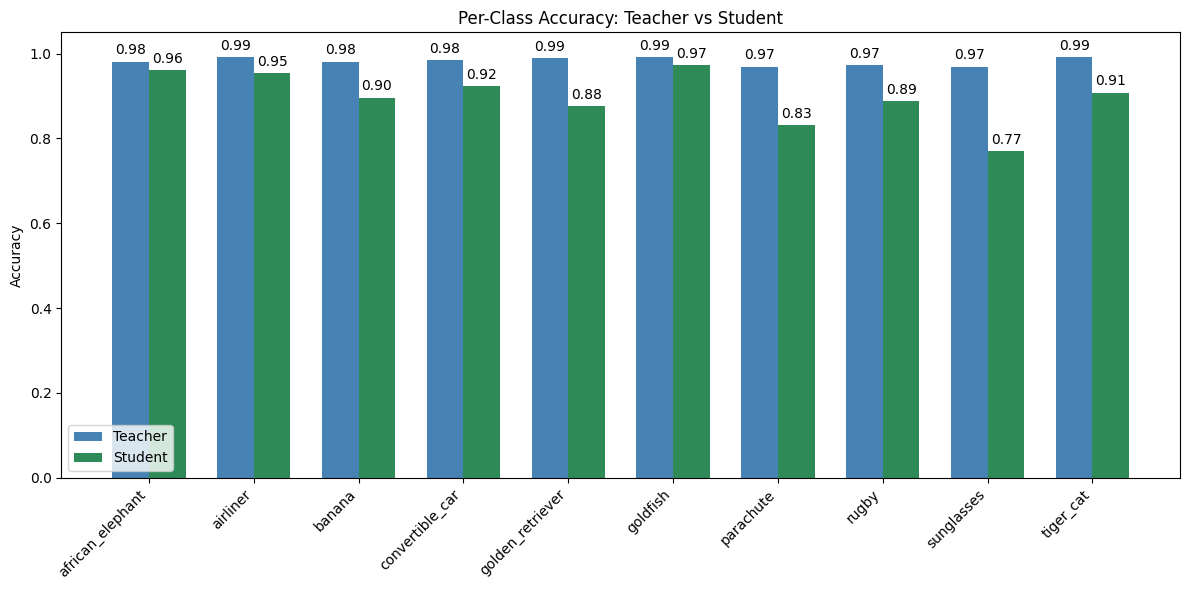

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


n_classes = len(class_names)

def per_class_accuracy(y_true, y_pred, n_classes):
    correct = np.zeros(n_classes)
    total = np.zeros(n_classes)
    for t, p in zip(y_true, y_pred):
        total[t] += 1
        if t == p:
            correct[t] += 1
    acc = correct / total
    return acc

acc_teacher = per_class_accuracy(y_true, teacher_preds, n_classes)
acc_student = per_class_accuracy(y_true, student_preds, n_classes)

# visualize per-class accuracy
x = np.arange(n_classes)
width = 0.35


fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, acc_teacher, width, label='Teacher', color='steelblue')
ax.bar(x + width/2, acc_student, width, label='Student', color='seagreen')

# annotate the bars with accuracy values
for i in range(n_classes):
    ax.text(x[i] - width/2, acc_teacher[i] + 0.01, f"{acc_teacher[i]:.2f}", ha='center', va='bottom')
    ax.text(x[i] + width/2, acc_student[i] + 0.01, f"{acc_student[i]:.2f}", ha='center', va='bottom')

ax.set_ylabel('Accuracy')
ax.set_title('Per-Class Accuracy: Teacher vs Student')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_ylim(0, 1.05)
ax.legend()
plt.tight_layout()
plt.show()


## Visualize training losses over time

Extract training metrics from printed logs and store them in a DataFrame for analysis

d:\Anoconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anoconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anoconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anoconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

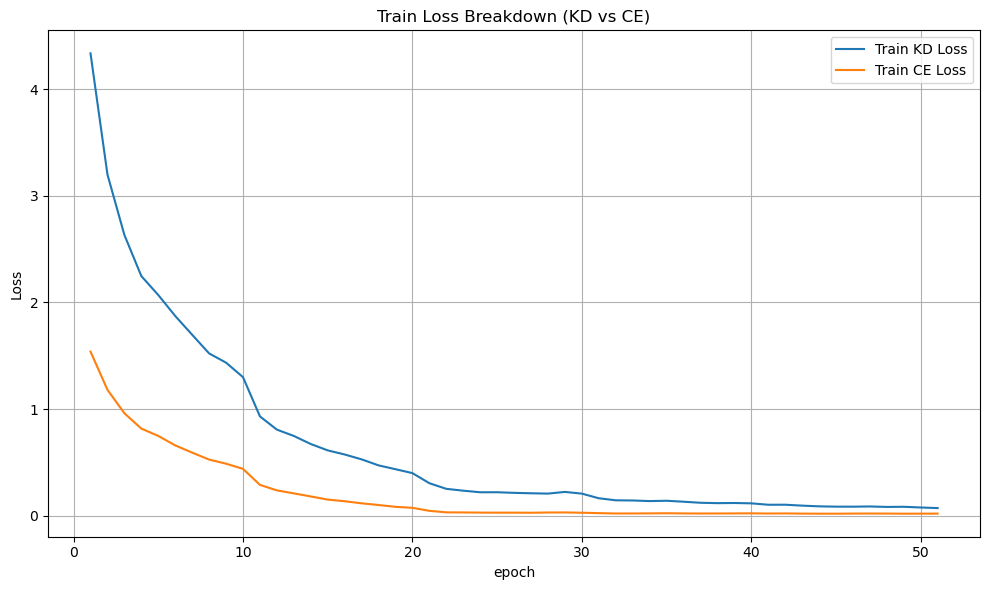

d:\Anoconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anoconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anoconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anoconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

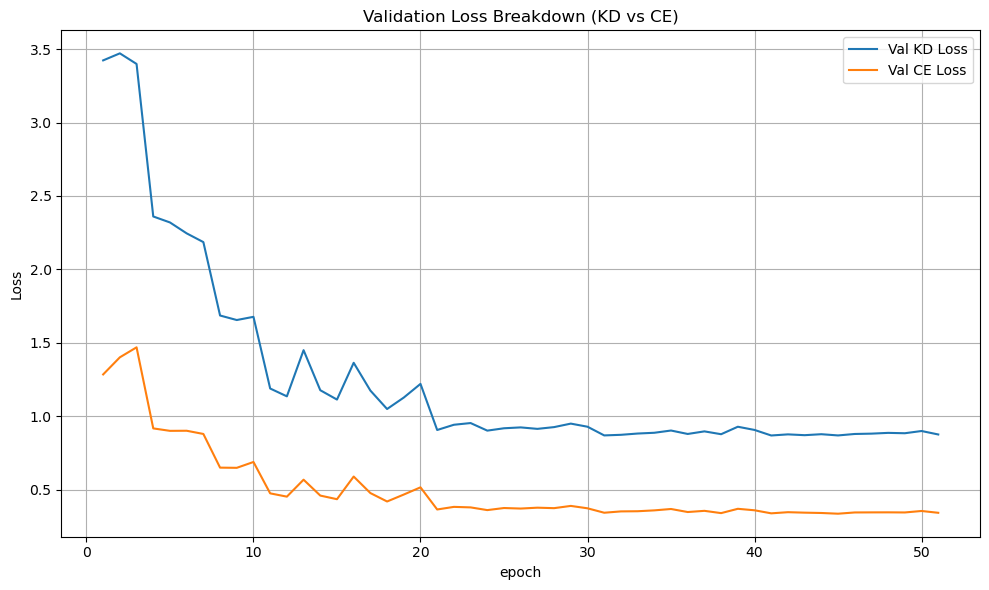

d:\Anoconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anoconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anoconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anoconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

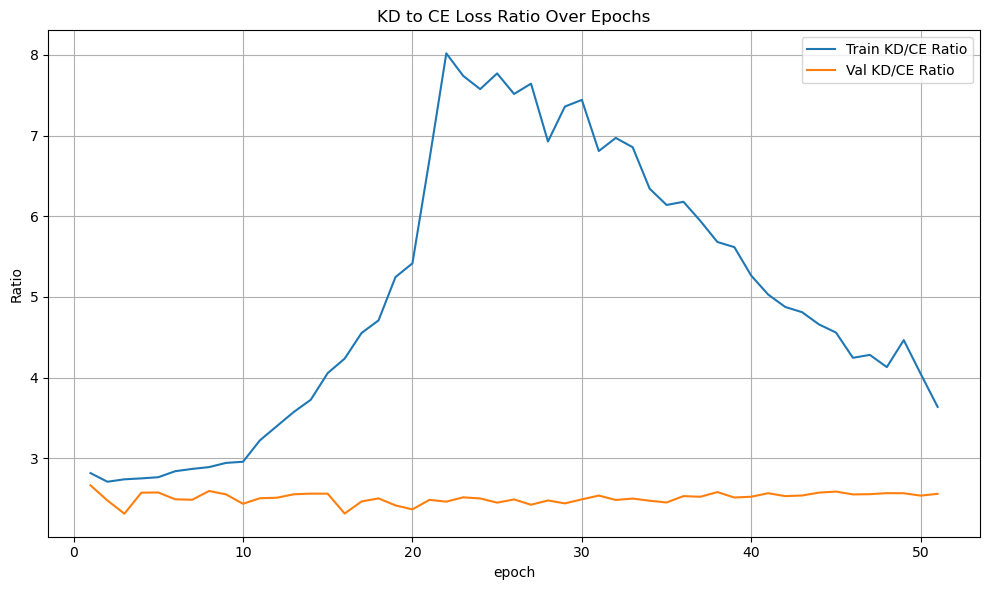

In [ ]:
# Manually construct the training log into a DataFrame from epochs 1 to 51
data = [
    (1, 3.4969, 4.3360, 1.5392, 0.5176, 2.7819, 3.4237, 1.2844, 0.6200),
    (2, 2.5942, 3.2000, 1.1807, 0.6494, 2.8504, 3.4716, 1.4010, 0.6327),
    (3, 2.1311, 2.6327, 0.9607, 0.7137, 2.8203, 3.3994, 1.4690, 0.6208),
    (4, 1.8179, 2.2471, 0.8166, 0.7594, 1.9273, 2.3604, 0.9168, 0.7458),
    (5, 1.6731, 2.0695, 0.7481, 0.7801, 1.8938, 2.3197, 0.9001, 0.7381),
    (6, 1.5088, 1.8729, 0.6593, 0.8037, 1.8420, 2.2454, 0.9008, 0.7562),
    (7, 1.3652, 1.6968, 0.5914, 0.8244, 1.7937, 2.1858, 0.8789, 0.7658),
    (8, 1.2232, 1.5219, 0.5263, 0.8418, 1.3749, 1.6858, 0.6495, 0.8142),
    (9, 1.1508, 1.4351, 0.4875, 0.8510, 1.3530, 1.6550, 0.6482, 0.8162),
    (10, 1.0413, 1.2994, 0.4393, 0.8663, 1.3802, 1.6768, 0.6880, 0.7992),
    (11, 0.7386, 0.9313, 0.2889, 0.9128, 0.9743, 1.1885, 0.4743, 0.8658),
    (12, 0.6362, 0.8071, 0.2374, 0.9273, 0.9302, 1.1352, 0.4519, 0.8696),
    (13, 0.5863, 0.7479, 0.2092, 0.9356, 1.1849, 1.4496, 0.5674, 0.8477),
    (14, 0.5246, 0.6722, 0.1804, 0.9445, 0.9616, 1.1769, 0.4592, 0.8604),
    (15, 0.4740, 0.6125, 0.1510, 0.9536, 0.9096, 1.1132, 0.4345, 0.8777),
    (16, 0.4424, 0.5740, 0.1355, 0.9594, 1.1312, 1.3637, 0.5888, 0.8381),
    (17, 0.4046, 0.5283, 0.1160, 0.9665, 0.9650, 1.1745, 0.4763, 0.8592),
    (18, 0.3604, 0.4719, 0.1002, 0.9713, 0.8599, 1.0489, 0.4189, 0.8800),
    (19, 0.3302, 0.4360, 0.0831, 0.9772, 0.9287, 1.1269, 0.4662, 0.8627),
    (20, 0.3016, 0.3992, 0.0737, 0.9801, 1.0086, 1.2200, 0.5153, 0.8546),
    (21, 0.2269, 0.3046, 0.0455, 0.9891, 0.7435, 0.9059, 0.3645, 0.8923),
    (22, 0.1857, 0.2518, 0.0314, 0.9951, 0.7737, 0.9416, 0.3822, 0.8862),
    (23, 0.1733, 0.2345, 0.0303, 0.9947, 0.7809, 0.9532, 0.3787, 0.8854),
    (24, 0.1625, 0.2197, 0.0290, 0.9953, 0.7392, 0.9016, 0.3602, 0.8923),
    (25, 0.1624, 0.2199, 0.0283, 0.9958, 0.7547, 0.9177, 0.3744, 0.8877),
    (26, 0.1585, 0.2142, 0.0285, 0.9955, 0.7578, 0.9236, 0.3708, 0.8865),
    (27, 0.1554, 0.2102, 0.0275, 0.9954, 0.7525, 0.9136, 0.3767, 0.8862),
    (28, 0.1540, 0.2071, 0.0299, 0.9954, 0.7600, 0.9256, 0.3735, 0.8896),
    (29, 0.1652, 0.2230, 0.0303, 0.9947, 0.7812, 0.9494, 0.3888, 0.8885),
    (30, 0.1532, 0.2069, 0.0278, 0.9954, 0.7615, 0.9282, 0.3725, 0.8862),
    (31, 0.1216, 0.1634, 0.0240, 0.9969, 0.7110, 0.8690, 0.3423, 0.8954),
    (32, 0.1072, 0.1443, 0.0207, 0.9985, 0.7166, 0.8731, 0.3514, 0.8946),
    (33, 0.1061, 0.1426, 0.0208, 0.9979, 0.7230, 0.8818, 0.3525, 0.8869),
    (34, 0.1024, 0.1370, 0.0216, 0.9982, 0.7284, 0.8870, 0.3584, 0.8908),
    (35, 0.1048, 0.1400, 0.0228, 0.9974, 0.7420, 0.9023, 0.3678, 0.8877),
    (36, 0.0981, 0.1310, 0.0212, 0.9979, 0.7194, 0.8789, 0.3471, 0.8962),
    (37, 0.0909, 0.1212, 0.0204, 0.9985, 0.7341, 0.8965, 0.3552, 0.8900),
    (38, 0.0885, 0.1176, 0.0207, 0.9987, 0.7159, 0.8772, 0.3397, 0.8938),
    (39, 0.0897, 0.1191, 0.0212, 0.9979, 0.7604, 0.9281, 0.3691, 0.8919),
    (40, 0.0876, 0.1158, 0.0220, 0.9974, 0.7421, 0.9063, 0.3590, 0.8896),
    (41, 0.0780, 0.1026, 0.0204, 0.9987, 0.7094, 0.8685, 0.3382, 0.8981),
    (42, 0.0784, 0.1029, 0.0211, 0.9985, 0.7170, 0.8761, 0.3460, 0.8942),
    (43, 0.0719, 0.0943, 0.0196, 0.9982, 0.7122, 0.8706, 0.3428, 0.8938),
    (44, 0.0669, 0.0876, 0.0188, 0.9992, 0.7162, 0.8772, 0.3406, 0.8923),
    (45, 0.0650, 0.0848, 0.0186, 0.9997, 0.7089, 0.8689, 0.3357, 0.8958),
    (46, 0.0651, 0.0845, 0.0199, 0.9988, 0.7184, 0.8788, 0.3442, 0.8938),
    (47, 0.0666, 0.0865, 0.0202, 0.9987, 0.7202, 0.8811, 0.3447, 0.8931),
    (48, 0.0635, 0.0822, 0.0199, 0.9987, 0.7239, 0.8863, 0.3450, 0.8923),
    (49, 0.0640, 0.0835, 0.0187, 0.9995, 0.7219, 0.8838, 0.3442, 0.8927),
    (50, 0.0595, 0.0769, 0.0190, 0.9995, 0.7356, 0.8990, 0.3542, 0.8900),
    (51, 0.0558, 0.0713, 0.0196, 0.9991, 0.7153, 0.8754, 0.3419, 0.8962),
]

# Create DataFrame
columns = [
    "epoch", "train_loss", "train_kd", "train_ce", "train_acc",
    "val_loss", "val_kd", "val_ce", "val_acc"
]
df = pd.DataFrame(data, columns=columns)

import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick

# Create lineplot of training loss breakdown
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="epoch", y="train_kd", label="Train KD Loss")
sns.lineplot(data=df, x="epoch", y="train_ce", label="Train CE Loss")
plt.ylabel("Loss")
plt.title("Train Loss Breakdown (KD vs CE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Create lineplot of validation loss breakdown
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="epoch", y="val_kd", label="Val KD Loss")
sns.lineplot(data=df, x="epoch", y="val_ce", label="Val CE Loss")
plt.ylabel("Loss")
plt.title("Validation Loss Breakdown (KD vs CE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Show KD / CE ratio change
df["train_kd_ce_ratio"] = df["train_kd"] / df["train_ce"]
df["val_kd_ce_ratio"] = df["val_kd"] / df["val_ce"]

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="epoch", y="train_kd_ce_ratio", label="Train KD/CE Ratio")
sns.lineplot(data=df, x="epoch", y="val_kd_ce_ratio", label="Val KD/CE Ratio")
plt.ylabel("Ratio")
plt.title("KD to CE Loss Ratio Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Comparison of Computational Efficiency

In [44]:
import torch
import torchvision.models as models
import time
import os

# Function to count total number of parameters (in millions)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) / 1e6

# Function to measure average inference time per image (ms)
def measure_inference_time(model, device, input_size=(1, 3, 224, 224), runs=100):
    model.eval()
    input_tensor = torch.randn(input_size).to(device)
    
    # Warm-up
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_tensor)

        # Timing
        start = time.time()
        for _ in range(runs):
            _ = model(input_tensor)
        end = time.time()

    avg_time_ms = (end - start) / runs * 1000
    return avg_time_ms

# Function to save model and get file size in MB
def get_model_size(model, filename='temp.pth'):
    torch.save(model.state_dict(), filename)
    size_MB = os.path.getsize(filename) / 1024 / 1024
    os.remove(filename)
    return size_MB

# Load both models
teacher = models.resnet34()
student = models.resnet18()

# Choose device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher = teacher.to(device)
student = student.to(device)

# Gather statistics
stats = {
    "Teacher (ResNet34)": {
        "Params (M)": count_parameters(teacher),
        "Model Size (MB)": get_model_size(teacher),
        "Inference Time (ms/img)": measure_inference_time(teacher, device)
    },
    "Student (ResNet18)": {
        "Params (M)": count_parameters(student),
        "Model Size (MB)": get_model_size(student),
        "Inference Time (ms/img)": measure_inference_time(student, device)
    }
}

# Print results
for name, values in stats.items():
    print(f"\n{name}")
    for k, v in values.items():
        print(f"{k}: {v:.2f}")



Teacher (ResNet34)
Params (M): 21.80
Model Size (MB): 83.27
Inference Time (ms/img): 95.77

Student (ResNet18)
Params (M): 11.69
Model Size (MB): 44.66
Inference Time (ms/img): 75.97
